In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# load in feature file
df_all = pd.read_csv('./Output/Submission/features/Features_Rescaled.csv')
df_all = df_all[df_all['ContourType'] == 'Manual']

fts_all = df_all['Feature'].unique()
patIDs = df_all['PatID'].unique()
fractions = df_all['Fraction'].unique()

In [3]:
fts_lng_icc = pd.read_csv('./Output/Submission/features/Manual_ICC_Names.csv')
fts_lng_icc = fts_lng_icc['Feature'].unique()
fts_lng_vol = pd.read_csv('./Output/Submission/features/Manual_VolCorr_TP_Names.csv')
fts_lng_vol = fts_lng_vol['Feature'].unique()

fts_del_icc = pd.read_csv('./Output/Submission-Delta/features/Manual_ICC_Names.csv')
fts_del_icc = fts_del_icc['Feature'].unique()
fts_del_vol = pd.read_csv('./Output/Submission-Delta/features/Manual_VolCorr_TP_Names.csv')
fts_del_vol = fts_del_vol['Feature'].unique()


In [4]:
# get number in common
fts_common_icc = np.intersect1d(fts_del_icc, fts_lng_icc)
print('Number of features in common with ICC:', len(fts_common_icc))

fts_common_vol = np.intersect1d(fts_del_vol, fts_lng_vol)
print('Number of features in common with VolCorr:', len(fts_common_vol))

Number of features in common with ICC: 15
Number of features in common with VolCorr: 12


In [5]:
# remove common fts from fts all
print('Number of features in all:', len(fts_all))

fts_all = np.setdiff1d(fts_all, fts_common_icc)
fts_all = np.setdiff1d(fts_all, fts_common_vol)

print('Number of features not in common:', len(fts_all))

Number of features in all: 105
Number of features not in common: 81


In [6]:
# for each feature get difference from frac A > frac B
def get_change(df_ft, ft, fracA, fracB):
    '''
    Get the change in feature value from frac A to frac B
    '''
    fts_valsA = df_ft[df_ft['Fraction'] == fracA]['FeatureValue'].values
    fts_valsB = df_ft[df_ft['Fraction'] == fracB]['FeatureValue'].values
    ft_vals1 = df_ft[df_ft['Fraction'] == 1]['FeatureValue'].values

    df_change_temp = pd.DataFrame({'PatID': df_ft['PatID'].unique()})
    df_change_temp['Feature'] = ft
    df_change_temp['Comp'] = f'{fracA} - {fracB}'
    df_change_temp['Change'] = (abs(fts_valsB - fts_valsA))

    return df_change_temp


def get_mean_change(df_change):
    '''
    Get the mean change in feature value
    '''
    df_change_mean = df_change.groupby(['Feature', 'Comp'])['Change'].mean().reset_index()
    # df_change_mean.drop(['PatID'], axis=1, inplace=True)
    
    return df_change_mean


def get_max_change_mean(df_change_mean):
    '''
    Get the maximum mean change in feature value and keep Comp
    '''
    df_change_max_mean = df_change_mean.loc[df_change_mean.groupby('Feature')['Change'].idxmax()]
    
    
    return df_change_max_mean

def get_max_change(df_change):
    '''
    Get the maximum change in feature value and the comp at which it occurs for every patient
    '''
    fts = df_change['Feature'].unique()
    patIDs = df_change['PatID'].unique()

    df_change_max = pd.DataFrame()

    for ft in fts:
        df_ft = df_change[df_change['Feature'] == ft]
        
        for pat in patIDs:
            df_pat = df_ft[df_ft['PatID'] == pat]
            
            # get row with max change
            max_change = df_pat['Change'].max()
            df_pat_max = df_pat[df_pat['Change'] == max_change]
    
    
            df_change_max = pd.concat([df_change_max, df_pat_max])
    
    return df_change_max

def get_max_change_no_delta(df_change):
    df_change = df_change[df_change['Comp'] != '1 - 5']

    fts = df_change['Feature'].unique()
    patIDs = df_change['PatID'].unique()

    df_change_max = pd.DataFrame()

    for ft in fts:
        df_ft = df_change[df_change['Feature'] == ft]
        
        for pat in patIDs:
            df_pat = df_ft[df_ft['PatID'] == pat]
            
            # get row with max change
            max_change = df_pat['Change'].max()
            df_pat_max = df_pat[df_pat['Change'] == max_change]
    
    
            df_change_max = pd.concat([df_change_max, df_pat_max])
    
    return df_change_max


In [7]:
# get the change in feature value for each feature
df_change = pd.DataFrame()

for ft in fts_all:
    df_ft = df_all[df_all['Feature'] == ft]

    for i in range(int(len(fractions))):
        fracA = fractions[i]
        for j in range(i+1, int(len(fractions))):
            fracB = fractions[j]

            df_change_temp = get_change(df_ft, ft, fracA, fracB)
            df_change = pd.concat([df_change, df_change_temp], axis=0)

df_change

,PatID,Feature,Comp,Change
0,1642,firstorder_10Percentile,1 - 2,0.274194
1,713,firstorder_10Percentile,1 - 2,0.096774
2,1483,firstorder_10Percentile,1 - 2,0.370968
3,1089,firstorder_10Percentile,1 - 2,0.064516
4,829,firstorder_10Percentile,1 - 2,0.000000
...,...,...,...,...
15,826,shape_Maximum3DDiameter,4 - 5,0.043662
16,1601,shape_Maximum3DDiameter,4 - 5,0.025725
17,1481,shape_Maximum3DDiameter,4 - 5,0.093194
18,1431,shape_Maximum3DDiameter,4 - 5,0.014449


In [8]:
df_mean_change = get_mean_change(df_change)
df_mean_change

,Feature,Comp,Change
0,firstorder_10Percentile,1 - 2,0.151210
1,firstorder_10Percentile,1 - 3,0.164919
2,firstorder_10Percentile,1 - 4,0.179435
3,firstorder_10Percentile,1 - 5,0.133468
4,firstorder_10Percentile,2 - 3,0.091129
...,...,...,...
805,shape_Maximum3DDiameter,2 - 4,0.063271
806,shape_Maximum3DDiameter,2 - 5,0.067151
807,shape_Maximum3DDiameter,3 - 4,0.054142
808,shape_Maximum3DDiameter,3 - 5,0.067946


In [9]:
# df_max_change_mean = get_max_change(df_mean_change)
# df_max_change_mean

In [10]:
# df_max_change_mean.value_counts('Comp')

In [11]:
df_max_change_no_delta = get_max_change_no_delta(df_change)
df_max_change_no_delta

,PatID,Feature,Comp,Change
0,1642,firstorder_10Percentile,1 - 2,0.274194
1,713,firstorder_10Percentile,1 - 3,0.112903
2,1483,firstorder_10Percentile,3 - 5,0.483871
3,1089,firstorder_10Percentile,3 - 5,0.225806
4,829,firstorder_10Percentile,4 - 5,0.080645
...,...,...,...,...
15,826,shape_Maximum3DDiameter,3 - 4,0.149333
16,1601,shape_Maximum3DDiameter,2 - 4,0.126647
17,1481,shape_Maximum3DDiameter,3 - 4,0.130966
18,1431,shape_Maximum3DDiameter,1 - 3,0.052036


In [12]:
df_max_change_all = get_max_change(df_change)

# do value counts as a percentage
df_max_change_all['Comp'].value_counts(normalize=True) * 100


2 - 5    18.087063
1 - 5    17.473942
1 - 4    15.879828
1 - 3    11.955855
1 - 2     8.338443
3 - 5     8.154506
4 - 5     6.866953
2 - 4     5.579399
3 - 4     4.966278
2 - 3     2.697731
Name: Comp, dtype: float64

In [13]:
df_bar_change_all = df_max_change_all.value_counts('Comp')
df_bar_change_all = df_bar_change_all.reset_index()

df_bar_change_all = df_bar_change_all.rename(columns={0: 'Count'})

# sort by Comp 
df_bar_change_all = df_bar_change_all.sort_values('Comp')
df_bar_change_all['Model'] = 'Longitudinal'

# change row with 1-5 Comp, Model to Delta
df_bar_change_all.loc[df_bar_change_all['Comp'] == '2 - 5', 'Model'] = 'Delta'

df_bar_change_all['Percentage'] = df_bar_change_all['Count'] / df_bar_change_all['Count'].sum() * 100


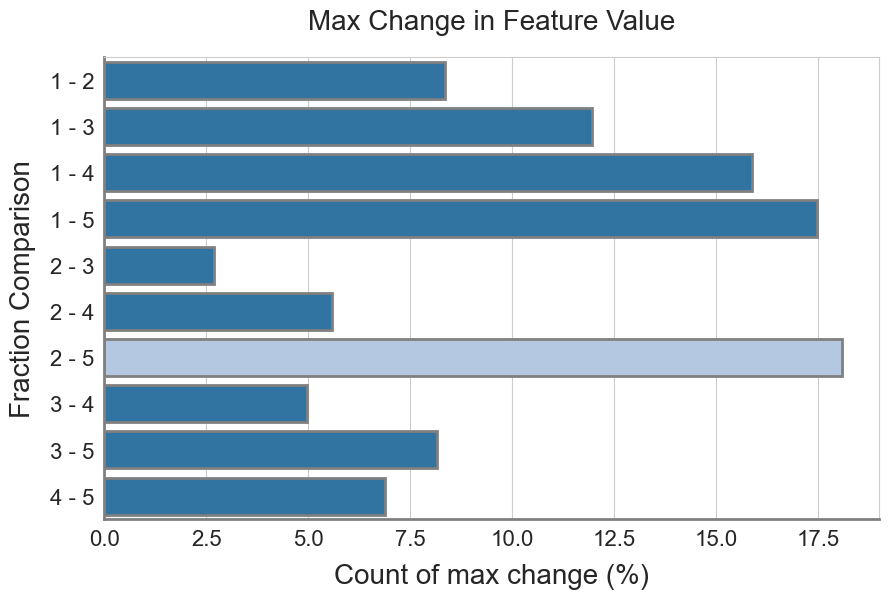

In [14]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
# plt.figure(figsize=(10, 6))
sns.barplot(x='Percentage', y='Comp', data=df_bar_change_all, palette='tab20',
            edgecolor='grey', linewidth=2, hue='Model', dodge=False)
# change color of one bar


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# add legend

# turn off legend
plt.legend().remove()


#plt.legend(title='Model', title_fontsize='16', fontsize='14', loc='lower right')
# plt.legend(title='Model', title_fontsize='16', fontsize='14', title_pad=20)

plt.xlabel('Count of max change (%)', fontsize=20, labelpad = 10)
plt.ylabel('Fraction Comparison', fontsize=20, labelpad = 10)
plt.title('Max Change in Feature Value', fontsize=20, pad=20)


for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('grey')




In [15]:
# for each feature get delta values (frac 1 - frac 5)
#                      max change values (frac A - frac B)
# perform MW rank test between delta and max change values

def get_comp_values(df_all_ft, df_max_change_ft):
    '''
    Get the feature values for the max change comparison and the delta comparison
    '''
    patIDs = df_all['PatID'].unique()
    
    df_result = pd.DataFrame()

    # get the max change values
    for pat in patIDs:
        max_change_comp = df_max_change_ft[df_max_change_ft['PatID'] == pat]['Comp'].values[0]
        max_change_val = df_max_change_ft[df_max_change_ft['PatID'] == pat]['Change'].values[0]

        # get delta value
        frac1_val = df_all_ft[(df_all_ft['PatID'] == pat) & (df_all_ft['Fraction'] == 1)]['FeatureValue'].values[0]
        frac5_val = df_all_ft[(df_all_ft['PatID'] == pat) & (df_all_ft['Fraction'] == 5)]['FeatureValue'].values[0]
        delta_val = abs(frac5_val - frac1_val)

        df_result_temp = pd.DataFrame({'PatID': pat, 'Comp': max_change_comp,'MaxChange': max_change_val, 'Delta': delta_val}, index=[0])
        df_result = pd.concat([df_result, df_result_temp])

    return df_result
        
        # get delta values
        





    return fts_max_change, fts_delta

def compare_max_delta(fts_max_change, fts_delta):
    '''
    Perform MW test between max change values and delta values
    '''
    from scipy.stats import mannwhitneyu
    
    stat, p = mannwhitneyu(fts_max_change, fts_delta)
    
    return stat, p

In [16]:
# loop through fts

df_MW = pd.DataFrame()
df_comp = pd.DataFrame()

for ft in fts_all:
    df_all_ft = df_all[df_all['Feature'] == ft]
    df_max_change_ft = df_max_change_all[df_max_change_all['Feature'] == ft]

    df_comp_values = get_comp_values(df_all_ft, df_max_change_ft)
    df_comp_values['Feature'] = ft

    df_comp = pd.concat([df_comp, df_comp_values])
    # print('-'*30)
    # print(ft)
    # print(df_comp_values[['Comp', 'MaxChange', 'Delta']])
    # # get MW rank test
    stat, p = compare_max_delta(df_comp_values['Delta'], df_comp_values['MaxChange'])
    # print(f'Value: {stat}, significance: {p}')
    df_MW_temp = pd.DataFrame({'Feature': ft, 'Stat': stat, 'p': p}, index=[0])
    df_MW = pd.concat([df_MW, df_MW_temp])

df_MW


,Feature,Stat,p
0,firstorder_10Percentile,93.0,0.003949
0,firstorder_90Percentile,99.5,0.006812
0,firstorder_Energy,64.5,0.000260
0,firstorder_Entropy,121.0,0.033684
0,firstorder_InterquartileRange,109.5,0.014842
...,...,...,...
0,ngtdm_Complexity,124.0,0.041086
0,ngtdm_Contrast,127.5,0.051429
0,ngtdm_Strength,130.0,0.060039
0,shape_MajorAxisLength,77.5,0.000965


In [17]:
df_MW_sig = df_MW[df_MW['p'] < 0.05]

fts_not_sig = np.setdiff1d(fts_all, df_MW_sig['Feature'].unique())
print(fts_not_sig)
df_MW_sig

['firstorder_MeanAbsoluteDeviation' 'firstorder_Variance'
 'glcm_ClusterProminence' 'glcm_ClusterShade' 'glcm_ClusterTendency'
 'glcm_Contrast' 'glcm_DifferenceVariance' 'glcm_SumSquares'
 'gldm_GrayLevelVariance' 'gldm_SmallDependenceEmphasis'
 'gldm_SmallDependenceHighGrayLevelEmphasis' 'glrlm_GrayLevelVariance'
 'glszm_GrayLevelNonUniformityNormalized'
 'glszm_HighGrayLevelZoneEmphasis' 'glszm_SizeZoneNonUniformity'
 'glszm_SmallAreaHighGrayLevelEmphasis' 'ngtdm_Contrast' 'ngtdm_Strength']


,Feature,Stat,p
0,firstorder_10Percentile,93.0,0.003949
0,firstorder_90Percentile,99.5,0.006812
0,firstorder_Energy,64.5,0.000260
0,firstorder_Entropy,121.0,0.033684
0,firstorder_InterquartileRange,109.5,0.014842
...,...,...,...
0,glszm_ZoneEntropy,85.5,0.002041
0,glszm_ZonePercentage,111.5,0.017267
0,ngtdm_Complexity,124.0,0.041086
0,shape_MajorAxisLength,77.5,0.000965


In [18]:
# get mean delta and max change values for significant features
df_comp_mean = df_comp.groupby('Feature').mean().reset_index()
df_comp_mean_sig = df_comp_mean[df_comp_mean['Feature'].isin(df_MW_sig['Feature'].unique())]

df_comp_mean_sig

,Feature,PatID,MaxChange,Delta
0,firstorder_10Percentile,1184.75,0.262500,0.133468
1,firstorder_90Percentile,1184.75,0.220503,0.124497
2,firstorder_Energy,1184.75,0.119612,0.043957
3,firstorder_Entropy,1184.75,0.244558,0.158432
4,firstorder_InterquartileRange,1184.75,0.183824,0.118750
...,...,...,...,...
74,glszm_ZoneEntropy,1184.75,0.160048,0.087148
75,glszm_ZonePercentage,1184.75,0.269858,0.189827
76,ngtdm_Complexity,1184.75,0.185758,0.121072
79,shape_MajorAxisLength,1184.75,0.142957,0.080596


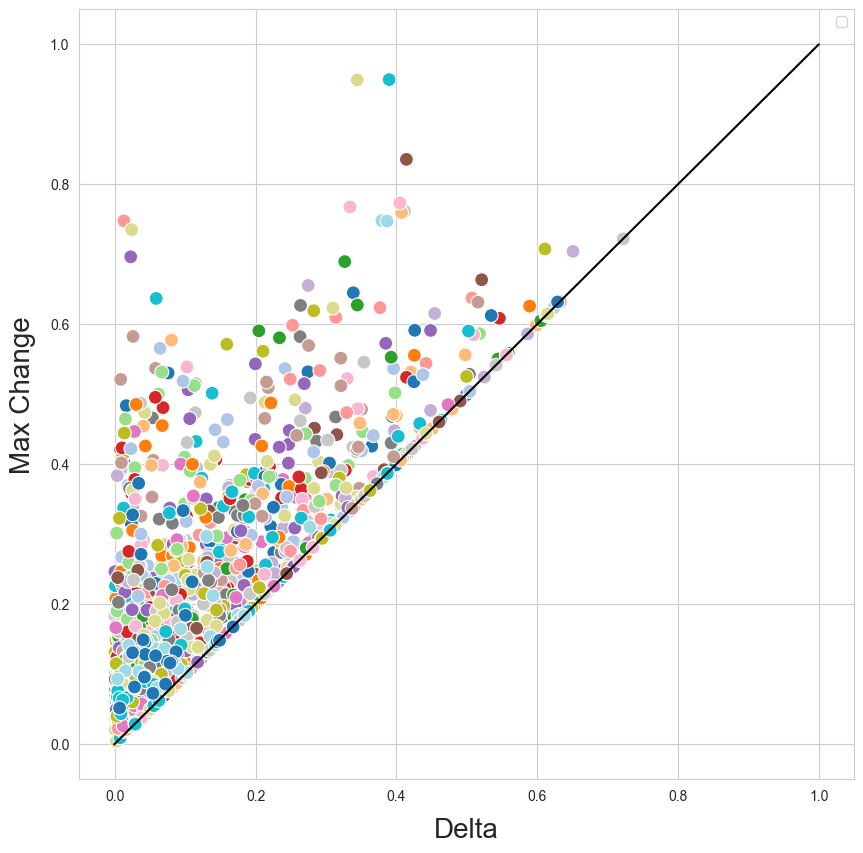

In [19]:
# identity plot for significant features
# x-axis is delta, y-axis is max change
# plot identity line
# plot points for each feature

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='Delta', y='MaxChange', data=df_comp, hue='Feature', palette='tab20', s=100)
plt.plot([-0.001, 1], [0, 1], 'k-')
plt.xlabel('Delta', fontsize=20, labelpad=10)
plt.ylabel('Max Change', fontsize=20, labelpad=10)
plt.legend('')

In [20]:
df_comp_no_delta = pd.DataFrame() 
df_MW_no_delta = pd.DataFrame()

for ft in fts_all:
    df_all_ft = df_all[df_all['Feature'] == ft]
    df_max_change_ft = df_max_change_no_delta[df_max_change_no_delta['Feature'] == ft]

    df_comp_values = get_comp_values(df_all_ft, df_max_change_ft)
    df_comp_values['Feature'] = ft

    df_comp_no_delta = pd.concat([df_comp_no_delta, df_comp_values])
    # print('-'*30)
    # print(ft)
    # print(df_comp_values[['Comp', 'MaxChange', 'Delta']])
    # # get MW rank test
    stat, p = compare_max_delta(df_comp_values['Delta'], df_comp_values['MaxChange'])
    # print(f'Value: {stat}, significance: {p}')
    df_MW_temp = pd.DataFrame({'Feature': ft, 'Stat': stat, 'p': p}, index=[0])
    df_MW_no_delta = pd.concat([df_MW_no_delta, df_MW_temp])

df_MW_no_delta



,Feature,Stat,p
0,firstorder_10Percentile,98.0,0.006024
0,firstorder_90Percentile,105.5,0.010977
0,firstorder_Energy,65.0,0.000275
0,firstorder_Entropy,127.0,0.049864
0,firstorder_InterquartileRange,114.5,0.021411
...,...,...,...
0,ngtdm_Complexity,128.0,0.053103
0,ngtdm_Contrast,134.0,0.076431
0,ngtdm_Strength,135.0,0.081032
0,shape_MajorAxisLength,87.0,0.002341


In [21]:
# df_MW_no_delta_sig = df_MW_no_delta[df_MW_no_delta['p'] < 0.05]

# # identity plot for significant features
# # x-axis is delta, y-axis is max change
# # plot identity line

# df_comp_no_delta_sig = df_comp_no_delta[df_comp_no_delta['Feature'].isin(df_MW_no_delta_sig['Feature'].unique())]
# fts_lng = pd.read_csv('./Output/Submission/features/Features_Selected.csv')
# fts_lng = fts_lng['Feature'].unique()
# df_comp_no_delta_sig = df_comp_no_delta_sig[df_comp_no_delta_sig['Feature'].isin(fts_lng)]

# fig, ax = plt.subplots(figsize=(10, 10))
# sns.scatterplot(x='Delta', y='MaxChange', data=df_comp_no_delta_sig,
#                 s=100, color='skyblue', 
#                 edgecolor='white', linewidth=1, alpha=0.8)

# plt.plot([0, 1], [0, 1], color='grey', linewidth=2, linestyle='-', label='Line')

# # Set edge color
# #plt.plot([0, 1], [0, 1], color='grey', linewidth=3, linestyle='-', label='Line')

# plt.xlabel('Change from Fraction 1 to 5', fontsize=20, labelpad=10)
# plt.ylabel('Max Change', fontsize=20, labelpad=10)
# plt.legend('')
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)

# plt.xlim((0,1))
# plt.ylim((0,1))
# for axis in ['bottom','left']:
#     ax.spines[axis].set_linewidth(2)
#     ax.spines[axis].set_color('grey')

# plt.title('Change in Feature Value', fontsize=20, pad=20)

Text(0.5, 1.0, 'Change in Feature Value')

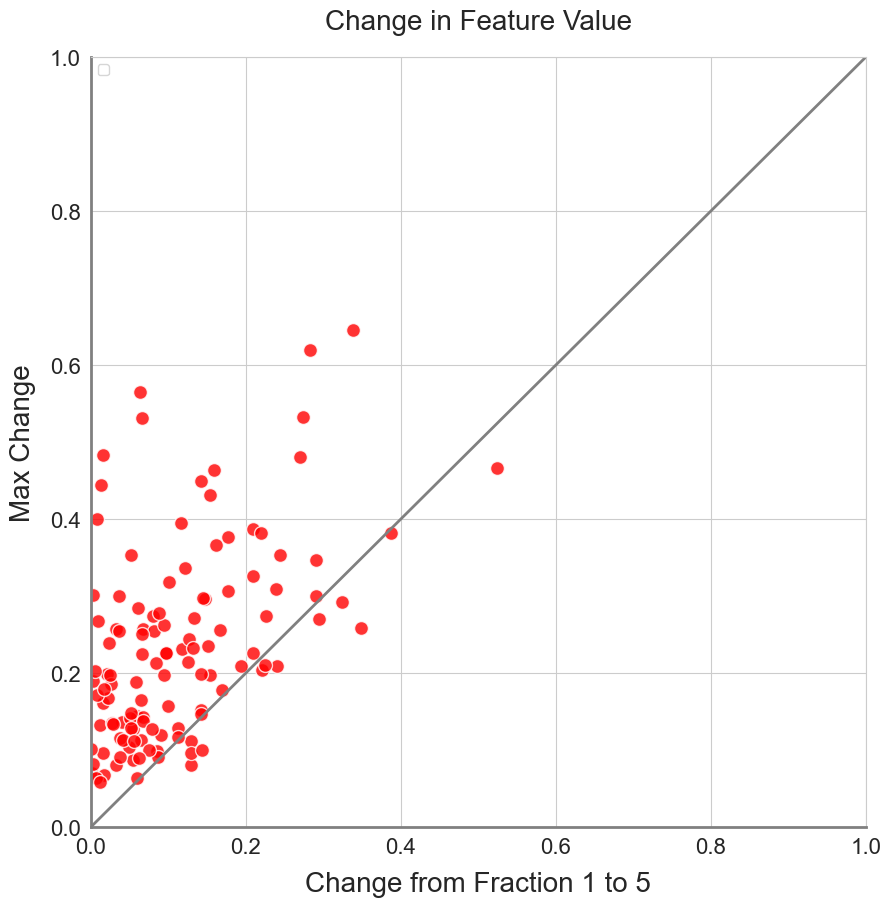

In [22]:
df_MW_no_delta_sig = df_MW_no_delta[df_MW_no_delta['p'] < 0.05]

# identity plot for significant features
# x-axis is delta, y-axis is max change
# plot identity line

df_comp_no_delta_sig = df_comp_no_delta[df_comp_no_delta['Feature'].isin(df_MW_no_delta_sig['Feature'].unique())]
fts_lng = pd.read_csv('./Output/Submission-Delta/features/Features_Selected.csv')
fts_lng = fts_lng['Feature'].unique()
df_comp_no_delta_sig = df_comp_no_delta_sig[df_comp_no_delta_sig['Feature'].isin(fts_lng)]

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='Delta', y='MaxChange', data=df_comp_no_delta_sig,
                s=100, color='red', 
                edgecolor='white', linewidth=1, alpha=0.8)

plt.plot([0, 1], [0, 1], color='grey', linewidth=2, linestyle='-', label='Line')

# Set edge color
#plt.plot([0, 1], [0, 1], color='grey', linewidth=3, linestyle='-', label='Line')

plt.xlabel('Change from Fraction 1 to 5', fontsize=20, labelpad=10)
plt.ylabel('Max Change', fontsize=20, labelpad=10)
plt.legend('')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim((0,1))
plt.ylim((0,1))
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('grey')

plt.title('Change in Feature Value', fontsize=20, pad=20)

In [23]:
fts_lng = pd.read_csv('./Output/Submission/features/Features_Selected.csv')
fts_lng = fts_lng['Feature'].unique()

fts_del = pd.read_csv('./Output/Submission-Delta/features/Features_Selected.csv')
fts_del = fts_del['Feature'].unique()

In [24]:
df_identity = df_MW_no_delta_sig.copy()
df_identity['Selected'] = 'No'

df_identity.loc[df_identity['Feature'].isin(fts_lng), 'Selected'] = 'Longitudinal'
df_identity.loc[df_identity['Feature'].isin(fts_del), 'Selected'] = 'Delta'

# merge with df_comp_no_delta_sig
df_identity = df_identity.merge(df_comp_no_delta_sig, on='Feature', how='left')
df_identity

,Feature,Stat,p,Selected,PatID,Comp,MaxChange,Delta
0,firstorder_10Percentile,98.0,0.006024,Delta,1642.0,1 - 2,0.274194,0.080645
1,firstorder_10Percentile,98.0,0.006024,Delta,713.0,1 - 3,0.112903,0.064516
2,firstorder_10Percentile,98.0,0.006024,Delta,1483.0,3 - 5,0.483871,0.016129
3,firstorder_10Percentile,98.0,0.006024,Delta,1089.0,3 - 5,0.225806,0.096774
4,firstorder_10Percentile,98.0,0.006024,Delta,829.0,4 - 5,0.080645,0.032258
...,...,...,...,...,...,...,...,...
167,glszm_LowGrayLevelZoneEmphasis,118.0,0.027483,No,NaN,NaN,NaN,NaN
168,glszm_ZoneEntropy,88.0,0.002561,No,NaN,NaN,NaN,NaN
169,glszm_ZonePercentage,117.0,0.025639,No,NaN,NaN,NaN,NaN
170,shape_MajorAxisLength,87.0,0.002341,No,NaN,NaN,NaN,NaN


In [25]:
df_identity_mean = df_identity.groupby('Feature').mean().reset_index()
df_identity_mean['Selected'] = df_identity.groupby('Feature')['Selected'].first().values
df_identity = df_identity.loc[df_identity['Selected'] != 'No']


df_identity

,Feature,Stat,p,Selected,PatID,Comp,MaxChange,Delta
0,firstorder_10Percentile,98.0,0.006024,Delta,1642.0,1 - 2,0.274194,0.080645
1,firstorder_10Percentile,98.0,0.006024,Delta,713.0,1 - 3,0.112903,0.064516
2,firstorder_10Percentile,98.0,0.006024,Delta,1483.0,3 - 5,0.483871,0.016129
3,firstorder_10Percentile,98.0,0.006024,Delta,1089.0,3 - 5,0.225806,0.096774
4,firstorder_10Percentile,98.0,0.006024,Delta,829.0,4 - 5,0.080645,0.032258
...,...,...,...,...,...,...,...,...
159,glrlm_ShortRunLowGrayLevelEmphasis,70.0,0.000460,Delta,826.0,1 - 4,0.250566,0.066107
160,glrlm_ShortRunLowGrayLevelEmphasis,70.0,0.000460,Delta,1601.0,1 - 4,0.382774,0.387694
161,glrlm_ShortRunLowGrayLevelEmphasis,70.0,0.000460,Delta,1481.0,1 - 3,0.178984,0.017682
162,glrlm_ShortRunLowGrayLevelEmphasis,70.0,0.000460,Delta,1431.0,3 - 5,0.063955,0.060014
